# Introduction

*This notebook explores the static-in-time interaction between two variables at different coupling values until they reach synchronization. For those interested in analyzing the temporal interaction between variables, please refer to the `temporal_data_tutorial` notebook.*

This notebook provides a tutorial on training a synthetic model using Temporal Autoencoders for Causal Inference (TACI) and evaluates it with bootstrapping techniques. We will go through each step from data generation to model evaluation and visualization of the results.

Our goal is to reproduce and understand some of the critical results presented in the corresponding research paper, emphasizing the impact of different system parameters and their interactions on model behavior and inference capabilities.


In [10]:
# Necessary Imports
import os, re, json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import tensorflow as tf
from tcn import tcn

from data.static_synthetic.Henon_maps import generate_henon03_henon03, henon03_henon03_plots
from data.static_synthetic.Rossler_Lorenz_attractors import generate_rossler_lorenz, rossler_lorenz_plots
from utilities.utils import create_model_parameters
from varying_coupling_static_synthetic_data import synthetic_model_full_handler, synthetic_model_boot_plot

# Ensure that TensorFlow does not log unnecessary messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # Set environment variable
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


## Henon Maps

### Data Generation

In this section, we generate synthetic data using the causal interaction between two Henon maps. This is a well-known discrete-time dynamical system that exhibits chaotic behavior. The Henon maps are defined by:

\begin{equation}
\begin{aligned} 
{x_1(t+1)} &= 1.4-x_1^2\left(t\right) + 0.3x_2\left(t\right)\\ 
{x_2(t+1)} &= x_1\left(t\right)\\ 
{y_1(t+1)} &= 1.4-\left(Cx_1\left(t\right)y_1\left(t\right) + \left(1-C\right)y_1^2\left(t\right)\right) + 0.3y_2\left(t\right)\\ 
{y_2(t+1)} &= y_1\left(t\right)\\ 
\end{aligned}
\end{equation}

The generated data here involves two Henon maps, where each has (a) parameter set at 0.3. The coupling parameter (C) controls the dynamics of the interaction. This parameter crucially influences the behavior of the coupled system, particularly its approach towards synchronization. As the coupling value increases, particularly around 0.7, the system tends to move towards a synchronized state.

Below, we visualize the generated data to understand the characteristics of this interaction. The plots will show how the dynamics evolve with different coupling values, highlighting the transition towards synchronization as the coupling increases.


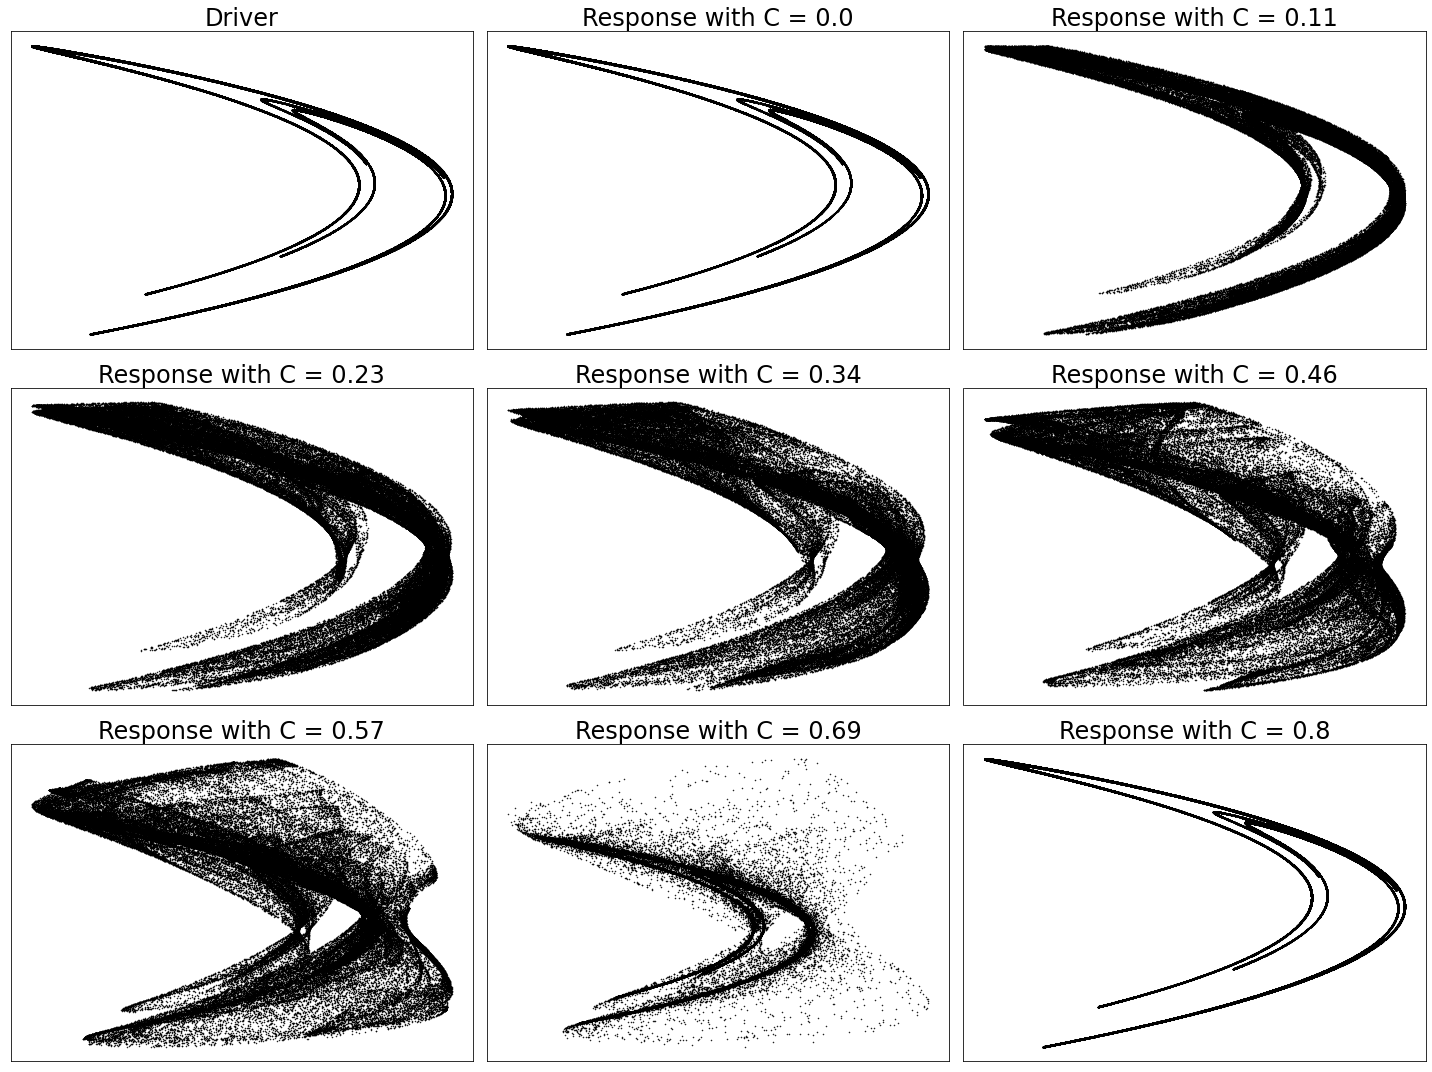

In [48]:
henon03_henon03_plots()

### Model Parameters

This section outlines the key parameters that control our model and data generation process. While some parameters are fixed to ensure model stability and consistency, you can adjust others to explore how they influence the model's performance.

#### Adjustable Parameters
- **`length_vars`**: The total number of data points generated for each run of the simulation. Increasing this number provides more data, which could enhance the model's ability to learn but also increases computational demands.
- **`discard`**: The number of initial data points to discard. This is used to remove the transient effects from the beginning of the simulation, ensuring the data reflects the stable behavior of the system.
- **`epochs`**: The number of times the entire dataset is passed forward and backward through the neural network. More epochs can lead to better learning but also risks overfitting if not monitored with validation data.
- **`encoder_type`**: Determines the method of data handling before feeding into the neural network. Set to `1` to include surrogate data, which is helpful for understanding model sensitivity to noise and testing robustness. Set to `2` for random data input, which tests the model’s ability to handle unexpected variations.

#### Fixed Parameters
- **Other Parameters**: Such as `batch_size`, `noise`, and `scaling_method` are set to default values optimized for typical use cases in our studies.


In [50]:
create_new_parameters_for_training = False

version = 1
models_folder = './logs/static_synthetic/Henon/'
encoder_type = 2
tol_default = 0.05

if create_new_parameters_for_training:
    
    model_parameters = create_model_parameters()

    # Define Henon Maps Specific Parameters
    model_parameters['model'] = 'generate_henon03_henon03'
    model_parameters['directory'] = models_folder + 'Version_' + str(version) + '/'
    model_parameters['method'] = None
    model_parameters['length_vars'] = 160000
    model_parameters['discard'] = 10000
    model_parameters['init_cond'] = [0.7, 0, 0.7, 0]
    model_parameters['var1'] = 0
    model_parameters['var2'] = 2    
    model_parameters['couplings'] = np.round(np.linspace(0.0, 0.8, 8), 2).tolist()
    model_parameters['seq_length'] = 10
    model_parameters['shift'] = 10
    model_parameters['lag'] = 10
    model_parameters['scaling_method'] = 'Standard'
    model_parameters['encoder_type'] = encoder_type
    model_parameters['noise'] = 0.1
    model_parameters['dropout_rate_tcn'] = 0.0
    model_parameters['dropout_rate_hidden'] = 0.0
    model_parameters['tol_default'] = tol_default
    model_parameters['batch_size'] = 512
    model_parameters['epochs'] = 300
    model_parameters['bootstraps_samples'] = 100
    
    # Save Parameters
    if not os.path.exists(model_parameters['directory']):
        os.makedirs(model_parameters['directory'])

    dicname = model_parameters['directory'] + 'parameters.json'
    with open(dicname, 'w') as f:
        json.dump(model_parameters, f, indent=4)

    dicname = model_parameters['directory'] + 'parameters.txt'
    with open(dicname, 'w') as f: 
        for key, value in model_parameters.items(): 
            f.write('%s:%s\n' % (key, value))

    function_name = model_parameters['model']
    if function_name in globals():
        model_parameters['model'] = globals()[function_name]
    else:
        print("Function not found.")

    print(model_parameters)


### Model Training and Prediction

We will now train a TACI model on the generated synthetic data. The model's architecture and training logs will be displayed.


Loading Scores ... 



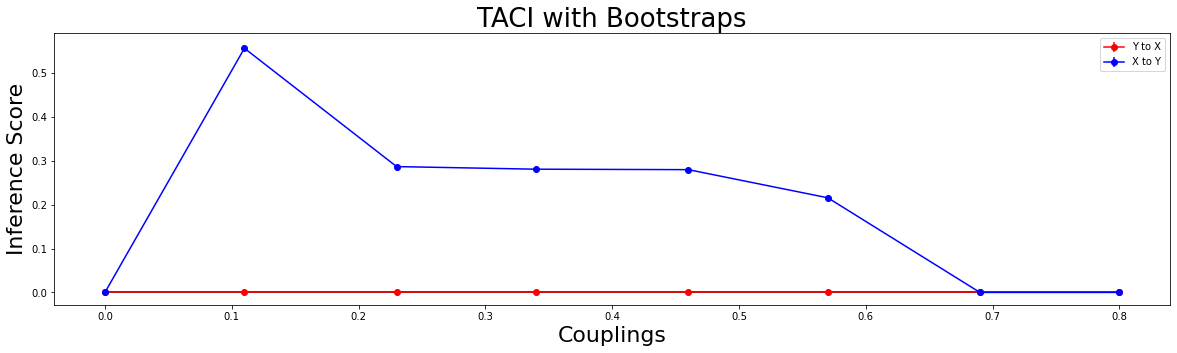

In [51]:
train_model = False

if train_model:
    synthetic_model_full_handler(model_parameters)
else: # Reload Saved Parameters 
    model_parameters={}
    model_parameters['directory'] = models_folder + 'Version_' + str(version) + '/'
    parameters_dir = model_parameters['directory'] + 'parameters.json'

    with open(parameters_dir, 'r') as f:
        model_parameters = json.load(f)
        
model_parameters['paint_fig'] = True
synthetic_model_boot_plot(model_parameters)

## Rössler-Lorenz

### Model Parameters

This section details the parameters that govern the behavior and output of the Rössler-Lorenz model simulations. Like the previous models, certain parameters are adaptable to allow for experimentation, while others remain fixed to maintain the integrity and stability of the simulations.


In [56]:
create_new_parameters_for_training = False

version = 1
models_folder = './logs/static_synthetic/Rossler_Lorenz/'
encoder_type = 2
tol_default = 0.05

if create_new_parameters_for_training:
    
    model_parameters = create_model_parameters()

    # Define Henon Maps Specific Parameters
    model_parameters['model'] = 'generate_rossler_lorenz'
    model_parameters['directory'] = models_folder + 'Version_' + str(version) + '/'
    model_parameters['method'] = 'odeint'
    model_parameters['length_vars'] = 160000
    model_parameters['discard'] = 10000
    model_parameters['init_cond'] = [0, 0, 0.4, 0.3, 0.3, 0.3]
    model_parameters['var1'] = 1
    model_parameters['var2'] = 4    
    model_parameters['couplings'] = np.round(np.linspace(0.0, 3.0, 8), 2).tolist()
    model_parameters['seq_length'] = 50
    model_parameters['shift'] = 50
    model_parameters['lag'] = 50
    model_parameters['scaling_method'] = 'Standard'
    model_parameters['encoder_type'] = encoder_type
    model_parameters['noise'] = 0.1
    model_parameters['dropout_rate_tcn'] = 0.0
    model_parameters['dropout_rate_hidden'] = 0.0
    model_parameters['tol_default'] = tol_default
    model_parameters['batch_size'] = 512
    model_parameters['epochs'] = 300
    model_parameters['bootstraps_samples'] = 100

    # Save Parameters
    if not os.path.exists(model_parameters['directory']):
        os.makedirs(model_parameters['directory'])

    dicname = model_parameters['directory'] + 'parameters.json'
    with open(dicname, 'w') as f:
        json.dump(model_parameters, f, indent=4)

    dicname = model_parameters['directory'] + 'parameters.txt'
    with open(dicname, 'w') as f: 
        for key, value in model_parameters.items(): 
            f.write('%s:%s\n' % (key, value))

    function_name = model_parameters['model']
    if function_name in globals():
        model_parameters['model'] = globals()[function_name]
    else:
        print("Function not found.")

    print(model_parameters)


### Data Generation

In this section, we generate synthetic data using the causal interaction between the Rössler and Lorenz systems. These are famous examples of continuous-time dynamical systems that exhibit chaotic behavior. The equations for these systems are defined as follows:

\begin{equation}
\begin{aligned} 
\dot{x}_{1} &=-6\left(x_{2}+x_{3}\right) \\ 
\dot{x}_{2} &=6\left(x_{1}+0.2 x_{2}\right) \\ 
\dot{x}_{3} &=6\left[0.2 + x_{3}\left(x_{1}-5.7\right)\right] \\ 
\dot{y}_{1} &=10\left(-y_{1}+y_{2}\right) \\ 
\dot{y}_{2} &=28 y_{1}-y_{2}-y_{1} y_{3} + C x_{2}^{2} \\ 
\dot{y}_{3} &=y_{1} y_{2}-\frac{8}{3} y_{3} 
\end{aligned}
\end{equation}

In these equations:
- The Rössler system is described by \(\dot{x}_{1}\), \(\dot{x}_{2}\), and \(\dot{x}_{3}\).
- The Lorenz system is described by \(\dot{y}_{1}\), \(\dot{y}_{2}\), and \(\dot{y}_{3}\).
- The coupling from the Rössler to the Lorenz system is introduced through the term \( C x_{2}^{2} \) in the Lorenz equation for \(\dot{y}_{2}\), where \( C \) is the coupling constant.

This setup allows us to explore how changes in the coupling constant \( C \) affect the synchronization phenomena between these two chaotic systems. As the coupling value increases, the interaction dynamics between the Rössler and Lorenz systems evolve, potentially leading to complex synchronization patterns.

Below, we visualize the generated data to observe the characteristics of this interaction. The plots will demonstrate how the system's behavior changes with varying coupling values, highlighting transitions and synchronization behaviors.


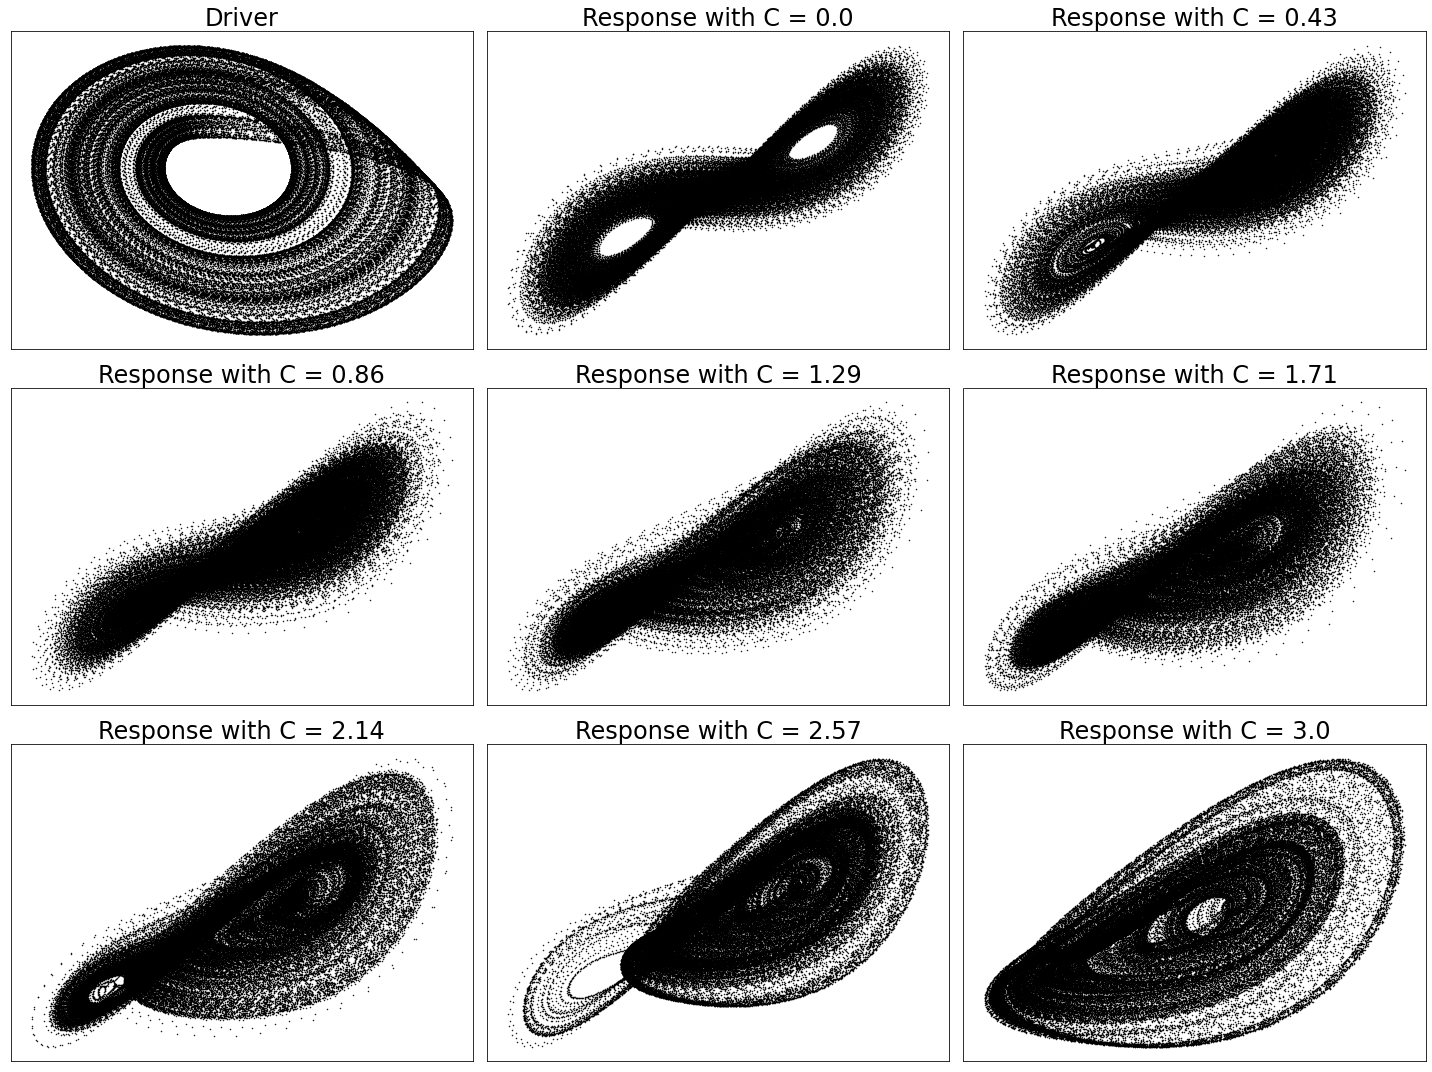

In [43]:
rossler_lorenz_plots()

### Model Training and Prediction

We will now train a TACI model on the generated synthetic data. The model's architecture and training logs will be displayed.


Loading Scores ... 



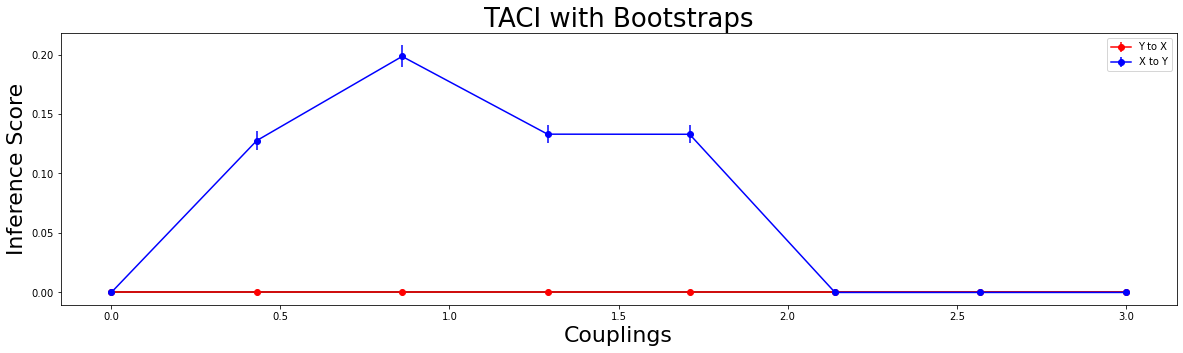

In [55]:
train_model = False

if train_model:
    synthetic_model_full_handler(model_parameters)
else: # Reload Saved Parameters 
    model_parameters={}
    model_parameters['directory'] = models_folder + 'Version_' + str(version) + '/'
    parameters_dir = model_parameters['directory'] + 'parameters.json'

    with open(parameters_dir, 'r') as f:
        model_parameters = json.load(f)
        
model_parameters['paint_fig'] = True
synthetic_model_boot_plot(model_parameters)